In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import numpy as np

In [348]:
res = pd.read_csv('../output/results50.csv')
#res = pd.read_csv('../output/results85.csv')
#res = pd.read_csv('../output/results65.csv')
#res = pd.read_csv('../output/results75.csv')
#res = pd.read_csv('../output/results80.csv')
#res = pd.concat([res60, res75, res85], axis=0)
res.head()

,Unnamed: 0,lab_id,drugA,drugB,ICxx,ICxxA,ICxxB,min_CI,Ca_min,Cb_min,Ca_range_lower,Ca_range_upper,Cb_range_lower,Cb_range_upper,equality_A,equality_B
0,0,10004,HESPERIDIN,TRAMETINIB,0.5,0.0,-1.554843,0.557693,[0.0045982],[0.01541547],0.004598,0.641540,0.009356,0.025400,greater_than,equal_to
1,1,10004,AZD4547,TRAMETINIB,0.5,0.0,-1.616059,0.799666,[0.0045982],[0.0192462],0.004598,0.108672,0.019246,0.022732,greater_than,equal_to
2,2,10004,NVP-ADW742,TRAMETINIB,0.5,0.0,-1.616059,1.686269,[0.5138491],[0.02838077],NaN,NaN,NaN,NaN,greater_than,equal_to
3,3,10004,GSK-690693,TRAMETINIB,0.5,0.0,-1.616059,0.608617,[0.20007187],[0.00988964],0.008466,0.757731,0.004303,0.018207,greater_than,equal_to
4,4,10004,CRIZOTINIB,TRAMETINIB,0.5,0.0,-1.607657,0.741858,[0.00411523],[0.0182074],0.004115,0.021742,0.018207,0.024029,greater_than,equal_to


In [349]:
bliss_beta = pd.read_csv('../data/bliss_beta_all.csv')[['Drug', '10004', '10292', '10336', '20003', '10326']].rename({'Drug':'inhibitor'}, axis=1)
bliss_beta = bliss_beta.assign(inhibitor = lambda x: [x.split(' ')[0].upper() for x in bliss_beta.inhibitor]).set_index('inhibitor').unstack().reset_index().rename({'level_0':'lab_id', 0:'bliss_beta_coef'}, axis=1)
bliss_beta.head()

,lab_id,inhibitor,bliss_beta_coef
0,10004,AXITINIB,1.16
1,10004,AZ960,1.05
2,10004,AZD4547,0.94
3,10004,BGB324,1.19
4,10004,CRIZOTINIB,0.97


In [350]:
res2 = res # res[lambda x: (x.ICxxA < 2) & (x.ICxxB < 2) & (x.min_CI < 10) ] # & (x.ICxxA > -7) & (x.ICxxB > -7)]
#res2 = res.replace(2, 1)

In [351]:
res3 = res2[['lab_id', 'drugA', 'min_CI']].rename({'drugA':'inhibitor'},axis=1).assign(lab_id = lambda x: x.lab_id.astype(str)).merge(bliss_beta, on=['lab_id', 'inhibitor'])
res3.head()

,lab_id,inhibitor,min_CI,bliss_beta_coef
0,10004,HESPERIDIN,0.557693,1.04
1,10004,AZD4547,0.799666,0.94
2,10004,NVP-ADW742,1.686269,0.88
3,10004,GSK-690693,0.608617,1.16
4,10004,CRIZOTINIB,0.741858,0.97


In [352]:
res3.corr(method='spearman')

,min_CI,bliss_beta_coef
min_CI,1.00000,-0.65522
bliss_beta_coef,-0.65522,1.00000


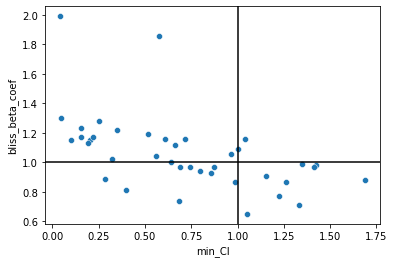

In [353]:
plt.figure()
sbn.scatterplot(x='min_CI', y='bliss_beta_coef', data=res3)
plt.axvline(1, c='k')
plt.axhline(1, c='k')
plt.show()

In [354]:
synergy_agree = res3[lambda x: (x.min_CI < 1) & (x.bliss_beta_coef > 1)]
print('# disagree:', synergy_agree.shape[0])
print('proportion disagree:', synergy_agree.shape[0] / res3.shape[0])
synergy_agree.groupby('inhibitor').count()[['min_CI']].sort_values('min_CI', ascending=False)

# disagree: 18
proportion disagree: 0.24


,min_CI
inhibitor,
GDC-0032,3
GSK-690693,3
BGB324,2
GILTERITINIB,2
GLESATINIB,2
SGX-523,2
AXITINIB,1
AZD4547,1
GEFITINIB,1


In [355]:
antag_agree = res3[lambda x: (x.min_CI > 1) & (x.bliss_beta_coef < 1)]
print('# disagree:', antag_agree.shape[0])
print('proportion disagree:', antag_agree.shape[0] / res3.shape[0])
antag_agree.groupby('inhibitor').count()[['min_CI']].sort_values('min_CI', ascending=False)

# disagree: 9
proportion disagree: 0.12


,min_CI
inhibitor,
I-BET762,2
NILOTINIB,2
NVP-ADW742,2
CRIZOTINIB,1
FULVESTRANT,1
HESPERIDIN,1


In [356]:
synergy_disagree = res3[lambda x: ((x.min_CI < 1) & (x.bliss_beta_coef < 1))]
print('# disagree:', synergy_disagree.shape[0])
print('proportion disagree:', synergy_disagree.shape[0] / res3.shape[0])
synergy_disagree.groupby('inhibitor').count()[['min_CI']].sort_values('min_CI', ascending=False)

# disagree: 9
proportion disagree: 0.12


,min_CI
inhibitor,
IXABEPOLONE,4
AZD4547,1
CRIZOTINIB,1
FULVESTRANT,1
GEFITINIB,1
MLN120B,1


In [357]:
synergy2_disagree = res3[lambda x: ((x.min_CI > 1) & (x.bliss_beta_coef > 1))]
print('# disagree:', synergy2_disagree.shape[0])
print('proportion disagree:', synergy2_disagree.shape[0] / res3.shape[0])
synergy2_disagree.groupby('inhibitor').count()[['min_CI']].sort_values('min_CI', ascending=False)

# disagree: 2
proportion disagree: 0.02666666666666667


,min_CI
inhibitor,
AXITINIB,1
GSK-690693,1


In [358]:
mat = res2[['lab_id', 'drugA', 'min_CI']].groupby(['lab_id', 'drugA']).agg('min').reset_index().rename({'drugA':'inhibitor'}, axis=1).pivot(index='inhibitor', columns='lab_id', values='min_CI')
mat

lab_id,10004,10292,10326,10336,20003
inhibitor,,,,,
AXITINIB,1.039638,0.152011,NaN,NaN,NaN
AZD4547,0.799666,0.965852,NaN,NaN,NaN
BGB324,0.513781,0.194432,NaN,NaN,NaN
CRIZOTINIB,0.741858,1.413887,NaN,NaN,NaN
FULVESTRANT,0.688737,1.151596,NaN,NaN,NaN
GDC-0032,0.046012,0.098846,NaN,NaN,0.042755
GEFITINIB,0.322209,0.873719,NaN,NaN,NaN
GILTERITINIB,0.350014,0.216768,NaN,NaN,NaN
GLESATINIB,0.250491,0.203512,NaN,NaN,NaN


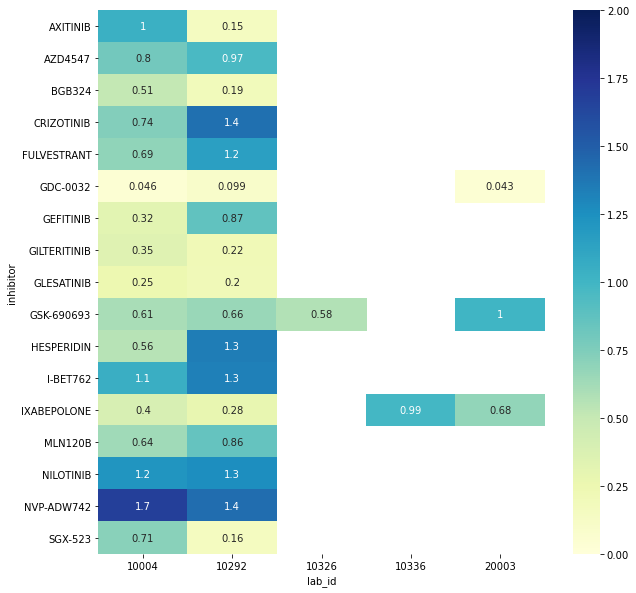

In [359]:
plt.figure(figsize=(10,10))

sbn.heatmap(mat, vmin=0, vmax=2, cmap="YlGnBu", annot=True, center=1)

plt.show()

<Figure size 432x288 with 0 Axes>

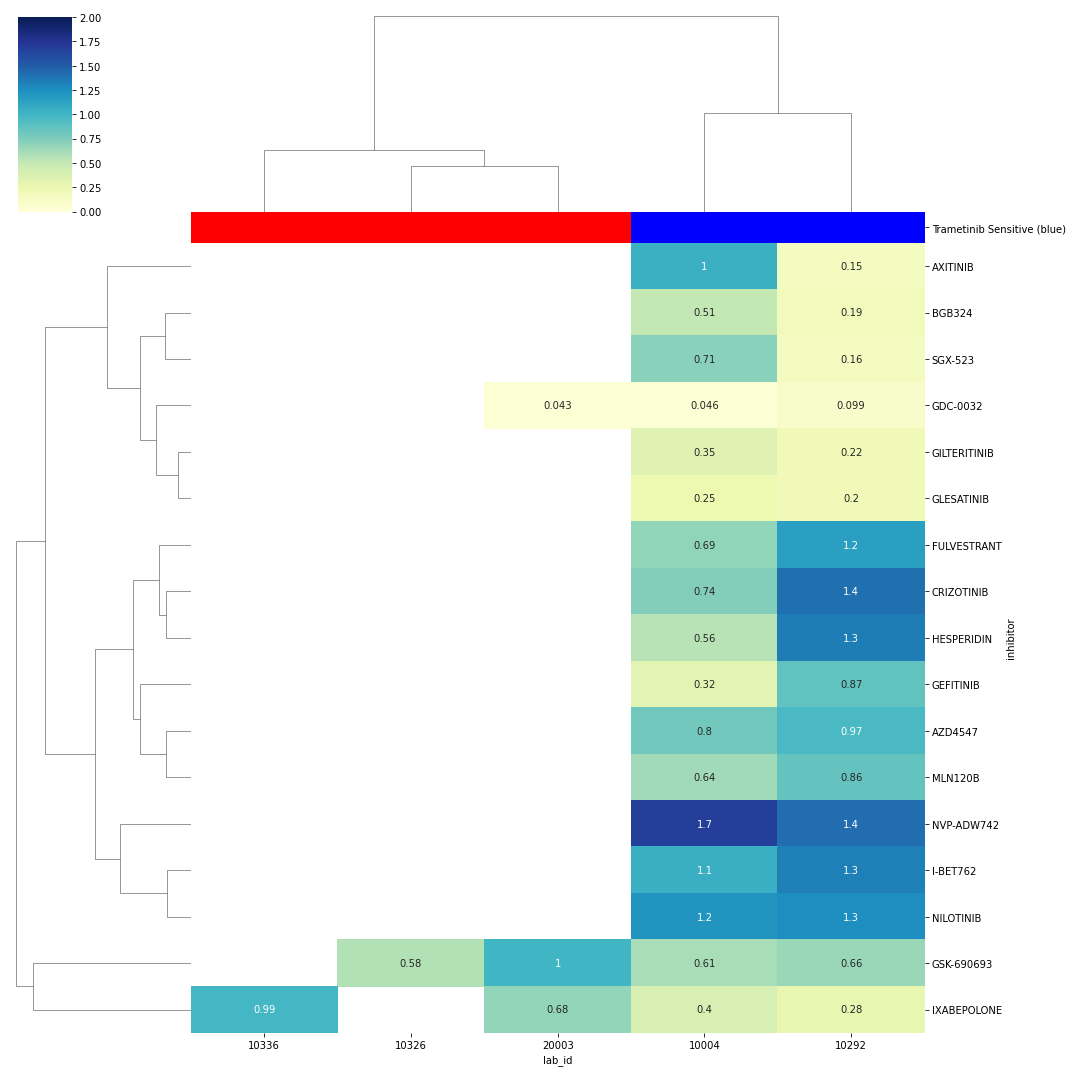

In [360]:
plt.figure()

colors = pd.DataFrame({20003:'r', 10292:'b', 10004:'b', 10336:'r', 10326:'r'}, index=[0]).T.rename({0:'Trametinib Sensitive (blue)'}, axis=1)

cg = sbn.clustermap(mat.fillna(0), col_colors=colors, vmin=0, vmax=2, center=1, cmap="YlGnBu", annot=True, mask=mat.isna(),figsize=(15,15))

plt.show()